<div class="alert alert-block alert-success">
<h1><b>PROJET 9 - </b>Réalisez une application de recommandation de contenu</h1>
<h2>Notebook Scripts</h2></div>

<img src="my_content.png" width="250" height="250">

## Table of Contents<hr>
[INTRODUCTION & PRESENTATION](#section_0)<br>
[A - IMPORTATIONS](#section_0A)<br>
[B - DATA COLLECTION & FIRST DATA DESCRIPTION](#section_0B)<br>
[C - EXPLORATORY DATA ANALYSIS](#section_0C)<br>
&emsp;[1 - Data Types](#section_0C1)<br>
&emsp;[2 - Summary](#section_0C2)<br>
&emsp;[3 - Vizualization](#section_0C3)<br>
[D - PERFORMANCE METRICS](#section_0D)<br>
&emsp;[1 - dsdsdssdsd](#section_0D1)<br><hr>
[PART 1 - DATA PREPARATION](#section_1)<br>
[A - PREPROCESSING](#section_1A)<br>
[B - EMBEDDING](#section_1B)<br>
[C - FINAL DATASETS FOR MODELLING](#section_1C)<br><hr>
[PART 2 - CONTENT-BASED APPROACH](#section_2)<br>
[A - PRESENTATION](#section_2A)<br><hr>
[PART 3 - COLLABORATIVE FILTERING APPROACH](#section_3)<br>
[A - PRESENTATION](#section_3A)<br><hr>
[CONCLUSION](#section_00)<br>

<h2><div class="alert alert-block alert-success" id="section_0">
INTRODUCTION & PRESENTATION</div></h2>

### Our mission

<b>My Content</b> is a start-up that wants to encourage reading by <b>recommending relevant content for its users</b>.<br><br>
The objective here is to <b>build a first MVP</b> which will take the form of an <b>application</b> which will initially <b>recommend five articles to the user</b>.

### Origin of the datasets

To perform the MVP, we will use <b>data available online</b>.<br>
This data <b>represents user interactions with available articles</b>.<br>
They contain information about articles (e.g. the number of words in the article), as well as information about user sessions (e.g. start and end times) and user interactions with articles (on what article did the user click during his session?).

### Software architectures

Dans la première architecture, tu crées une API pour développer puis exposer ton système de recommandation. Pour faire le lien entre l’application et le système de recommandation, tu crées une Azure Function

Dans la deuxième architecture, tu peux te passer de l’API, en exploitant les fonctionnalités “Azure Blob storage input binding” pour récupérer directement les fichiers et modèles, et en intégrant tes prédictions directement dans ton Azure Functions

Je te laisse choisir l’architecture que tu mettras en place !

Il est conseillé de créer votre Azure Function directement sur le portail Azure, et de choisir le “plan type” égal à “Consomption(serverless)”, afin d’utiliser l’option gratuite de Service Plan

Sélectionner l’architecture logicielle permettant de répondre au besoin métier :<br> 
    • les différentes briques d’architecture nécessaires pour la réalisation de la solution répondant au besoin métier ont été identifiées.<br>
    • la description fonctionnelle de chaque brique d’architecture a été réalisée.<br>
    • les besoins de mise à jour des bases de données Utilisateurs et Articles ont été pris en compte dans la description fonctionnelle.<br>
    • une explication sous forme de schéma des différentes briques de l’architecture logicielle a été élaborée.<br>
    

### Django Application

Pour l’application, tu peux créer en local une simple interface qui liste les id des users et affiche les résultats des 5 suggestions d’articles, suite à appel de l’Azure Functions.

 fichier “embeddings” : tu peux réaliser une réduction de dimension de ce fichier via une ACP.

une architecture serverless avec Azure Functions 

### What is a recommender system?

A recommendation system (or recommender system) is a AI algorithm that uses Big Data to suggest or recommend additional products to consumers. Data help predict, narrow down, and find what people are looking for among an exponentially growing number of options.

Recommendation systems exploit user preferences and traits to prioritize and recommend items which the users would like. It's used by large companies (like Amazon, Facebook, Google and Netflix) to drive significant customer engagement and revenue.<br>
In short, recommendation systems are systems that help users discover items they may like.

There are 2 common ways to implement a recommender system:<br>
    • Collaborative Filtering (CF)<br>
    • Content-Based Filtering (CBF)

We will describe this further down in the notebook.

### Recommender System algorithms

Concevoir des scripts permettant d’exécuter une chaîne de traitements IA bout-en-bout :<br>
• les scripts permettant d’entraîner et de tester le modèle de recommandation ont été développés et testés.<br>
• au moins un des algorithmes de chacune des deux approches (CF et content-based) de système de recommandation a été testé.<br>
• la fonction serverless renvoyant la prédiction du modèle intégrée à l’application mobile a été testée.

<h3><div class="alert alert-block alert-info" id="section_0A">
A - IMPORTATIONS</div></h3>

In [1]:
%matplotlib inline

# Importation of Python modules and methods.
import os
import random
import warnings
from glob import glob

# Importation of Machine Learning libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importation of a Recommender System library.
from surprise import Reader, Dataset
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split

# warnings.filterwarnings("ignore")
# os.environ['TF_CPP_MIN_LOG_LEVEL']='2'  # Only warning and error information is displayed.

<h3><div class="alert alert-block alert-info" id="section_0B">
B - DATA COLLECTION & FIRST DATA EXPLORATION</div></h3>

In [2]:
# Creation of pandas DataFrames with CSV files.
df_clicks = pd.read_csv(
    'datasets/clicks_sample.csv', sep=',', low_memory=False)
df_articles = pd.read_csv(
    'datasets/articles_metadata.csv', sep=',', low_memory=False)
# df_clicks_hour = pd.read_csv(
#     'datasets/clicks/clicks_hour_000.csv', sep=',', low_memory=False)

# Max display of rows and columns. 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 15)

# Style for the plots.
plt.style.use('fivethirtyeight')

## • df_clicks

#### Global information about the dataframe

In [3]:
# Information and shape about the df_clicks DataFrame.
df_clicks.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_clicks has {df_clicks.shape[0]} \
observations and {df_clicks.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_clicks.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   user_id              1883 non-null   int64
 1   session_id           1883 non-null   int64
 2   session_start        1883 non-null   int64
 3   session_size         1883 non-null   int64
 4   click_article_id     1883 non-null   int64
 5   click_timestamp      1883 non-null   int64
 6   click_environment    1883 non-null   int64
 7   click_deviceGroup    1883 non-null   int64
 8   click_os             1883 non-null   int64
 9   click_country        1883 non-null   int64
 10  click_region         1883 non-null   int64
 11  click_referrer_type  1883 non-null   int64
dtypes: int64(12)
memory usage: 176.7 KB

The dataset df_clicks has 1883 observations and 12 variables.


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
5,2,1506825435299739,1506825435000,2,30970,1506827120575,4,1,17,1,24,2
6,3,1506825442704740,1506825442000,2,236065,1506827536942,4,3,2,1,21,1
7,3,1506825442704740,1506825442000,2,236294,1506827566942,4,3,2,1,21,1
8,4,1506825528135741,1506825528000,2,48915,1506826927593,4,1,17,1,17,1
9,4,1506825528135741,1506825528000,2,44488,1506826957593,4,1,17,1,17,1


#### Missing values

In [4]:
print(f"\033[1mNumber of missing values in the df_clicks dataframe: \
{df_clicks.isna().sum().sum()}\033[0m")

Number of missing values in the df_clicks dataframe: 0


#### Unique values

In [5]:
# Function to calculate the number of unique values for each columns of a dataframe.
def unique_values(df, col_list):
    """Function to generate the unique values of each column of a dataframe."""
    for col in col_list:
        col_unique_values = df[col].nunique()
        print(f"Number of unique {col}: {col_unique_values}")

In [6]:
# Number of unique values for each columns of df_clicks. 
cols = df_clicks.columns.tolist()
unique_values(df_clicks, cols)

Number of unique user_id: 707
Number of unique session_id: 707
Number of unique session_start: 619
Number of unique session_size: 11
Number of unique click_article_id: 323
Number of unique click_timestamp: 1883
Number of unique click_environment: 3
Number of unique click_deviceGroup: 3
Number of unique click_os: 6
Number of unique click_country: 7
Number of unique click_region: 26
Number of unique click_referrer_type: 6


## • df_articles

#### Global information about the dataframe

In [7]:
# Information and shape about the df_articles DataFrame.
df_articles.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_articles has {df_articles.shape[0]} \
observations and {df_articles.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_articles.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   article_id     364047 non-null  int64
 1   category_id    364047 non-null  int64
 2   created_at_ts  364047 non-null  int64
 3   publisher_id   364047 non-null  int64
 4   words_count    364047 non-null  int64
dtypes: int64(5)
memory usage: 13.9 MB

The dataset df_articles has 364047 observations and 5 variables.


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


#### Missing values

In [8]:
print(f"\033[1mNumber of missing values in the df_articles dataframe: \
{df_articles.isna().sum().sum()}\033[0m")

Number of missing values in the df_articles dataframe: 0


#### Unique values

In [9]:
# Number of unique values for each columns of df_articles. 
cols = df_articles.columns.tolist()
unique_values(df_articles, cols)

Number of unique article_id: 364047
Number of unique category_id: 461
Number of unique created_at_ts: 359552
Number of unique publisher_id: 1
Number of unique words_count: 866


<h3><div class="alert alert-block alert-info" id="section_0C">
C - EXPLORATORY DATA ANALYSIS</div></h3>

<h4><div class="alert alert-block alert-warning" id="section_0C1">
1 - Data Types</div></h4>

In [10]:
# Function to change the data types.
def change_type(df, list_to_change, type_):
    """Changing the columns in the 'list_to_change' 
    into the indicated 'type_' from a specific dataframe df."""
    if type_ == 'datetime':
        for col in list_to_change:
            df[col] = pd.to_datetime(df[col])
    else:
        for col in list_to_change:
            df[col] = df[col].astype(type_)

## • df_clicks

In [11]:
# Changing data types of the df_clicks to gain speed and lower memory usage.

# Lists of variables for type changing.
uint8_list = ['session_size']
uint16_list = ['user_id']
uint32_list = ['click_article_id']
date_time_list = ['session_id', 'session_start', 'click_timestamp']
category_list = ['click_environment', 'click_deviceGroup', 
                 'click_os', 'click_country', 'click_region', 
                 'click_referrer_type']

# Changing the data types of the variables inside the lists.
change_type(df_clicks, uint8_list, 'uint8')
change_type(df_clicks, uint16_list, 'uint16')
change_type(df_clicks, uint32_list, 'uint32')
change_type(df_clicks, date_time_list, 'datetime')
change_type(df_clicks, category_list, 'category')

In [12]:
# Information and shape about the df_clicks DataFrame.
df_clicks.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_clicks has {df_clicks.shape[0]} \
observations and {df_clicks.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_clicks.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1883 non-null   uint16        
 1   session_id           1883 non-null   datetime64[ns]
 2   session_start        1883 non-null   datetime64[ns]
 3   session_size         1883 non-null   uint8         
 4   click_article_id     1883 non-null   uint32        
 5   click_timestamp      1883 non-null   datetime64[ns]
 6   click_environment    1883 non-null   category      
 7   click_deviceGroup    1883 non-null   category      
 8   click_os             1883 non-null   category      
 9   click_country        1883 non-null   category      
 10  click_region         1883 non-null   category      
 11  click_referrer_type  1883 non-null   category      
dtypes: category(6), datetime64[ns](3), uint16(1), uint32(1), uint8(1)
memory usage: 70.4 KB

T

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1970-01-18 10:33:45.423271737,1970-01-01 00:25:06.825423,2,157541,1970-01-01 00:25:06.826828020,4,3,20,1,20,2
1,0,1970-01-18 10:33:45.423271737,1970-01-01 00:25:06.825423,2,68866,1970-01-01 00:25:06.826858020,4,3,20,1,20,2
2,1,1970-01-18 10:33:45.426267738,1970-01-01 00:25:06.825426,2,235840,1970-01-01 00:25:06.827017951,4,1,17,1,16,2
3,1,1970-01-18 10:33:45.426267738,1970-01-01 00:25:06.825426,2,96663,1970-01-01 00:25:06.827047951,4,1,17,1,16,2
4,2,1970-01-18 10:33:45.435299739,1970-01-01 00:25:06.825435,2,119592,1970-01-01 00:25:06.827090575,4,1,17,1,24,2
5,2,1970-01-18 10:33:45.435299739,1970-01-01 00:25:06.825435,2,30970,1970-01-01 00:25:06.827120575,4,1,17,1,24,2
6,3,1970-01-18 10:33:45.442704740,1970-01-01 00:25:06.825442,2,236065,1970-01-01 00:25:06.827536942,4,3,2,1,21,1
7,3,1970-01-18 10:33:45.442704740,1970-01-01 00:25:06.825442,2,236294,1970-01-01 00:25:06.827566942,4,3,2,1,21,1
8,4,1970-01-18 10:33:45.528135741,1970-01-01 00:25:06.825528,2,48915,1970-01-01 00:25:06.826927593,4,1,17,1,17,1
9,4,1970-01-18 10:33:45.528135741,1970-01-01 00:25:06.825528,2,44488,1970-01-01 00:25:06.826957593,4,1,17,1,17,1


## • df_articles

In [13]:
# Changing data types of the df_articles to gain speed and lower memory usage.

# Lists of variables for type changing.
uint16_list = ['words_count']
uint32_list = ['article_id']
date_time_list = ['created_at_ts']
category_list = ['category_id', 'publisher_id']

# Changing the data types of the variables inside the lists.
change_type(df_articles, uint16_list, 'uint16')
change_type(df_articles, uint32_list, 'uint32')
change_type(df_articles, date_time_list, 'datetime')
change_type(df_articles, category_list, 'category')

In [14]:
# Information and shape about the df_articles DataFrame.
df_articles.info(memory_usage='deep')
print(f"\033[1m\nThe dataset df_articles has {df_articles.shape[0]} \
observations and {df_articles.shape[1]} variables.\033[0m")
# 10 first rows with all the columns.
df_articles.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364047 entries, 0 to 364046
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   article_id     364047 non-null  uint32        
 1   category_id    364047 non-null  category      
 2   created_at_ts  364047 non-null  datetime64[ns]
 3   publisher_id   364047 non-null  category      
 4   words_count    364047 non-null  uint16        
dtypes: category(2), datetime64[ns](1), uint16(1), uint32(1)
memory usage: 5.9 MB

The dataset df_articles has 364047 observations and 5 variables.


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1970-01-01 00:25:13.144419,0,168
1,1,1,1970-01-01 00:23:25.341936,0,189
2,2,1,1970-01-01 00:23:28.667706,0,250
3,3,1,1970-01-01 00:23:28.468313,0,230
4,4,1,1970-01-01 00:23:27.071171,0,162
5,5,1,1970-01-01 00:23:27.413929,0,196
6,6,1,1970-01-01 00:23:29.896802,0,203
7,7,1,1970-01-01 00:23:32.559620,0,154
8,8,1,1970-01-01 00:23:34.351550,0,209
9,9,1,1970-01-01 00:23:32.526792,0,181


<h4><div class="alert alert-block alert-warning" id="section_0C2">
2 - Summary</div></h4>

In [15]:
def resume_df(df):
    """Function to generate the main information of a dataframe."""
    print(f"Dataset shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isna().sum().values  
    summary['Unique'] = df.nunique().values
    summary['Fifth Value'] = df.loc[4].values
    summary['Mean'] = '-'
    summary['Median'] = '-'
    summary['Mode'] = '-'
    i = 0
    for name in summary['Name']:
        if name in ['session_size', 'words_count']:
            summary.loc[i, 'Mean'] = df[name].agg('mean').round(2)
            summary.loc[i, 'Median'] = df[name].agg('median').round(2)
            summary.loc[i, 'Mode'] = df[name].agg('mode')[0]
        elif df[name].dtype == 'category':
            summary.loc[i, 'Mode'] = df[name].agg('mode')[0]
        i += 1
    return summary

## • df_clicks

In [16]:
# Main information of the df_clicks dataframe.
df_resume = df_clicks.copy()
resume_df(df_resume)

Dataset shape: (1883, 12)


,Name,dtypes,Missing,Unique,Fifth Value,Mean,Median,Mode
0,user_id,uint16,0,707,2,-,-,-
1,session_id,datetime64[ns],0,707,1970-01-18 10:33:45.435299739,-,-,-
2,session_start,datetime64[ns],0,619,1970-01-01 00:25:06.825435,-,-,-
3,session_size,uint8,0,11,2,3.46,3.0,2
4,click_article_id,uint32,0,323,119592,-,-,-
5,click_timestamp,datetime64[ns],0,1883,1970-01-01 00:25:06.827090575,-,-,-
6,click_environment,category,0,3,4,-,-,4
7,click_deviceGroup,category,0,3,1,-,-,3
8,click_os,category,0,6,17,-,-,2
9,click_country,category,0,7,1,-,-,1


## • df_articles

In [17]:
# Main information of the df_articles dataframe.
df_resume = df_articles.copy()
resume_df(df_resume)

Dataset shape: (364047, 5)


,Name,dtypes,Missing,Unique,Fifth Value,Mean,Median,Mode
0,article_id,uint32,0,364047,4,-,-,-
1,category_id,category,0,461,1,-,-,281
2,created_at_ts,datetime64[ns],0,359552,1970-01-01 00:23:27.071171,-,-,-
3,publisher_id,category,0,1,0,-,-,0
4,words_count,uint16,0,866,162,190.9,186.0,176


In [18]:
del df_resume

<h4><div class="alert alert-block alert-warning" id="section_0C3">
3 - Visualization</div></h4>

## • df_clicks

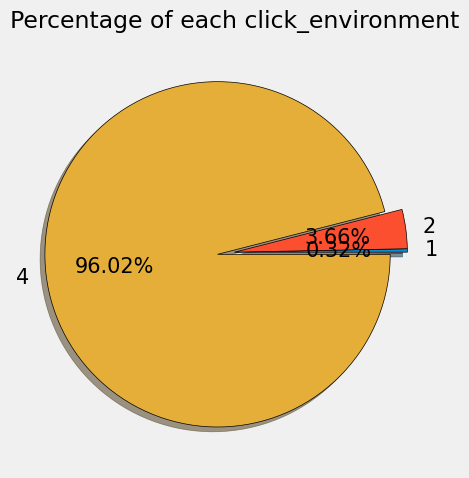

In [19]:
# Pie plot to display the percentage of each click_environment.
plt.figure(figsize=(5, 5))
labels=["1", "2", "4"]
slices = df_clicks.groupby("click_environment").size()
plt.pie(slices, 
        labels=labels, explode=[0, 0, 0.1], 
        shadow=True, startangle=0, autopct='%1.2f%%', 
        wedgeprops={'edgecolor': 'black'}, textprops={"fontsize":15})
plt.title("Percentage of each click_environment", fontsize=17)
plt.tight_layout()
plt.show()

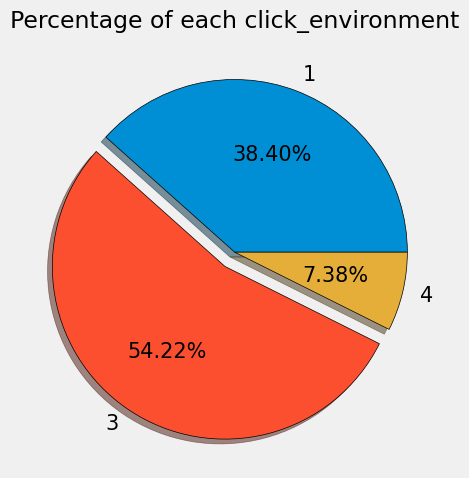

In [20]:
# Pie plot to display the percentage of each click_deviceGroup.
plt.figure(figsize=(5, 5))
labels=["1", "3", "4"]
slices = df_clicks.groupby("click_deviceGroup").size()
plt.pie(slices, 
        labels=labels, explode=[0, 0.1, 0], 
        shadow=True, startangle=0, autopct='%1.2f%%', 
        wedgeprops={'edgecolor': 'black'}, textprops={"fontsize":15})
plt.title("Percentage of each click_environment", fontsize=17)
plt.tight_layout()
plt.show()

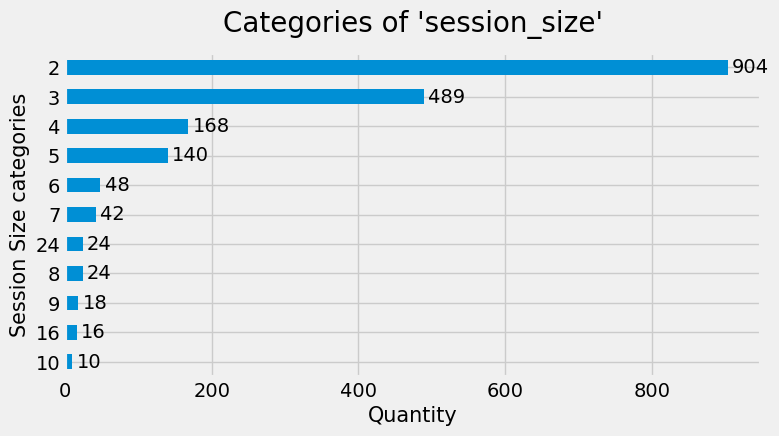

In [21]:
# Horizontal bar plot showing the different session_size and the respecting quantity.
ax = df_clicks['session_size'].value_counts().sort_values().plot.barh(
    figsize=(8, 4), fontsize=14)
plt.title("Categories of 'session_size'", fontsize=20, pad=15)
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Session Size categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

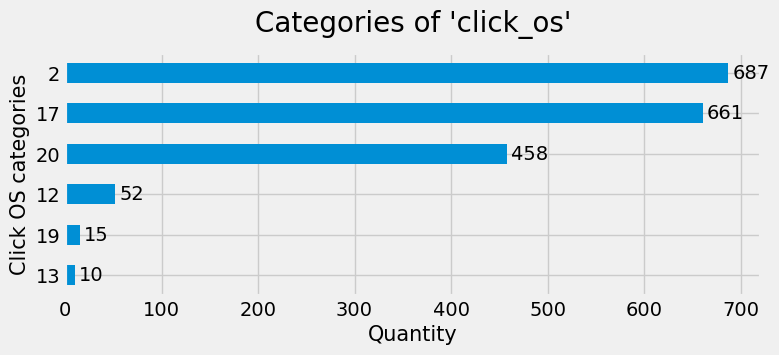

In [22]:
# Horizontal bar plot showing the different click_os and the respecting quantity.
ax = df_clicks['click_os'].value_counts().sort_values().plot.barh(
    figsize=(8, 3), fontsize=14)
plt.title("Categories of 'click_os'", fontsize=20, pad=15)
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Click OS categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

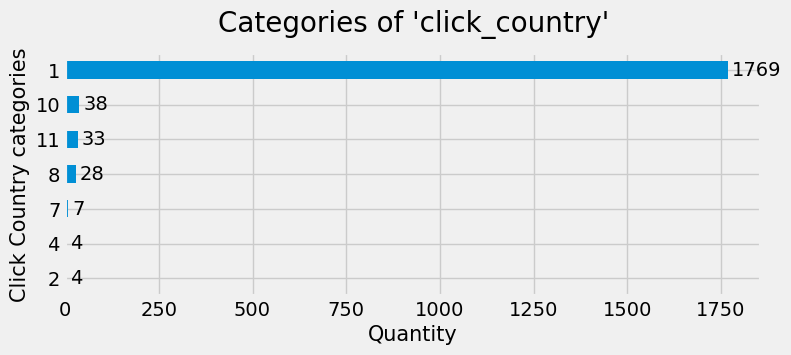

In [23]:
# Horizontal bar plot showing the different click_country and the respecting quantity.
ax = df_clicks['click_country'].value_counts().sort_values().plot.barh(
    figsize=(8, 3), fontsize=14)
plt.title("Categories of 'click_country'", fontsize=20, pad=15)
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Click Country categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

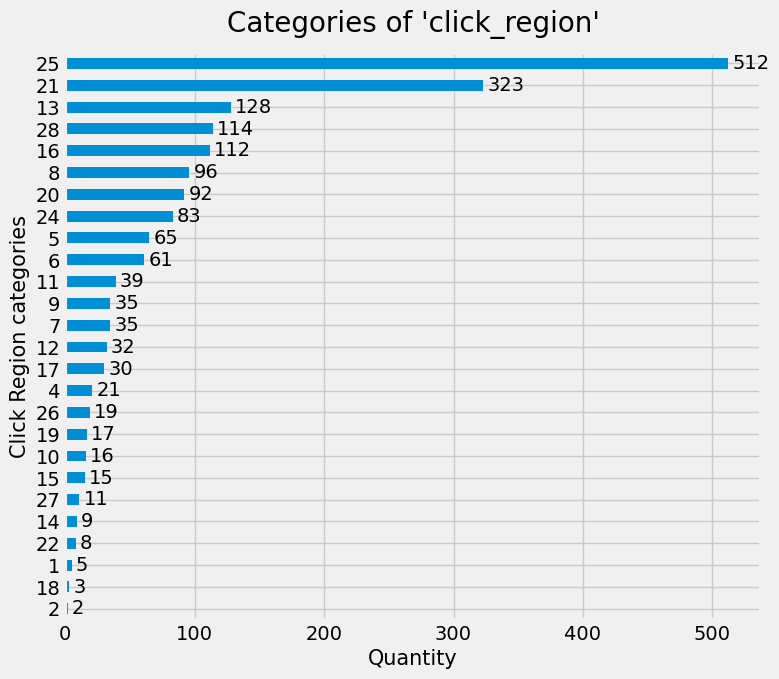

In [24]:
# Horizontal bar plot showing the different click_region and the respecting quantity.
ax = df_clicks['click_region'].value_counts().sort_values().plot.barh(
    figsize=(8, 7), fontsize=14)
plt.title("Categories of 'click_region'", fontsize=20, pad=15)
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Click Region categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

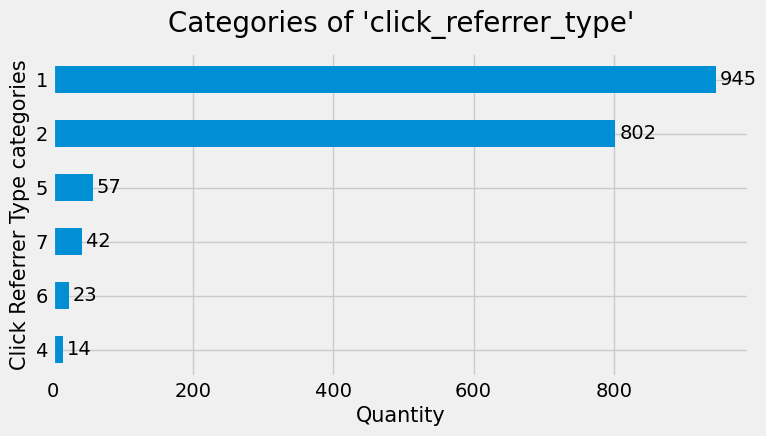

In [25]:
# Horizontal bar plot showing the different click_referrer_type and the respecting quantity.
ax = df_clicks['click_referrer_type'].value_counts().sort_values().plot.barh(
    figsize=(8, 4), fontsize=14)
plt.title("Categories of 'click_referrer_type'", fontsize=20, pad=15)
plt.xlabel("Quantity", fontsize=15)
plt.ylabel("Click Referrer Type categories", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

## • df_articles

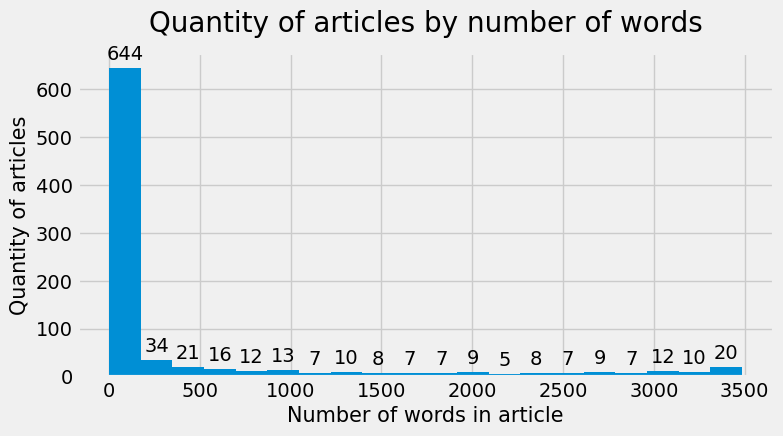

In [26]:
# Histogram showing the different words_count and the respecting quantity.
ax = df_articles['words_count'].value_counts().sort_values().plot.hist(bins=20, 
    figsize=(8, 4), fontsize=14)
plt.title("Quantity of articles by number of words", fontsize=20, pad=15)
plt.xlabel("Number of words in article", fontsize=15)
plt.ylabel("Quantity of articles", fontsize=15)
ax.bar_label(ax.containers[0], padding=3, fontsize=14)
plt.show()

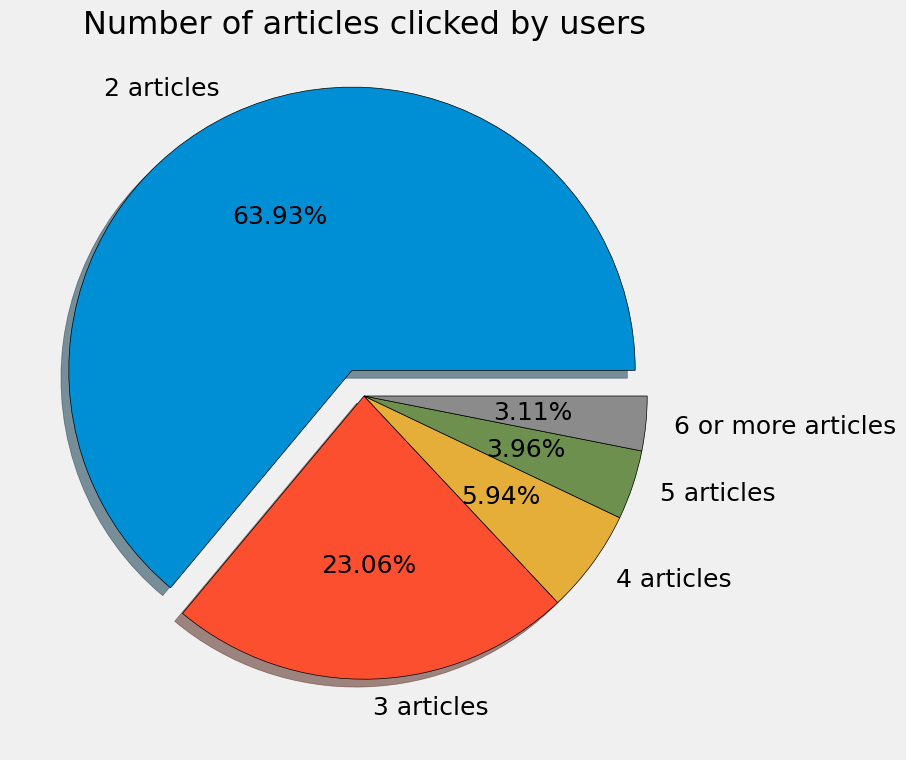

In [27]:
# Pie plot to display the percentage of articles clicked by users.
plt.figure(figsize=(9, 9))
slices = df_clicks.groupby("user_id")['click_article_id'].count()
art2 = 0
art3 = 0
art4 = 0
art5 = 0
art6_and_more = 0
for i in slices:
    if i == 2:
        art2 += 1
    elif i == 3:
        art3 += 1
    elif i == 4:
        art4 += 1
    elif i == 5:
        art5 += 1
    else:
        art6_and_more += 1
slices = [art2, art3, art4, art5, art6_and_more]
labels = ["2 articles", "3 articles", "4 articles", 
          "5 articles", "6 or more articles"]
explode = [0.1, 0, 0, 0, 0]
plt.pie(slices, labels=labels, explode=explode, shadow=True, startangle=0,
        autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'},
        textprops={"fontsize":18})
plt.title("Number of articles clicked by users", fontsize=23)
plt.tight_layout()
plt.show()

In [28]:
# df_clicks.groupby("user_id")['click_article_id'].count().sort_values()

In [29]:
# df_articles.words_count.value_counts().plot(kind='bar')
# plt.show()

In [30]:
# # Number of order(s) by 'customer_unique_id'.
# print('\033[1m' + "Number of order(s) by 'customer_unique_id':" +'\033[0m')
# df_customers.groupby("customer_unique_id").size().unique()

In [31]:
# # Top 20 of the city from where customers buy. 
# top_20_city_customers = df_customers.groupby(
#     ['customer_city'])['customer_unique_id'].count().sort_values(ascending=False)[:20]

# # Bar plotting the top 20 customers city.
# fig=plt.figure(figsize=(16,9))
# sns.barplot(y=top_20_city_customers.index, x=top_20_city_customers.values)
# plt.title('Top 20 City with most Customers', pad=15, fontsize=24)
# plt.xlabel('Number of customers', fontsize=20)
# plt.ylabel('City', fontsize=20)

In [32]:
# df_articles.words_count.value_counts()

In [34]:
# df_articles.category_id.unique()

[0, 1, 2, 3, 4, ..., 456, 457, 458, 459, 460]
Length: 461
Categories (461, int64): [0, 1, 2, 3, ..., 457, 458, 459, 460]

In [ ]:
# Number of order(s) by 'customer_unique_id'.
# print('\033[1m' + "Number of order(s) by 'unique_id':" +'\033[0m')
# df_clicks.groupby("unique_id").size().unique()

In [ ]:
# Top 20 of the city from where customers buy. 
# top_20_city_customers = df_customers.groupby(
#     ['customer_city'])['customer_unique_id'].count().sort_values(ascending=False)[:20]

# # Bar plotting the top 20 customers city.
# fig=plt.figure(figsize=(16,9))
# sns.barplot(y=top_20_city_customers.index, x=top_20_city_customers.values)
# plt.title('Top 20 City with most Customers', pad=15, fontsize=24)
# plt.xlabel('Number of customers', fontsize=20)
# plt.ylabel('City', fontsize=20)

In [ ]:
# Plotting the evolution of daily orders.
# orders_per_days = df_orders.groupby(
#     df_orders["order_purchase_timestamp"].astype('datetime64[ns]').dt.date).count()["order_id"]
# fig = plt.figure(figsize=(20, 8))
# ax = orders_per_days.plot(color="#00d994", fontsize=15)
# ax.set_ylabel("Count", fontsize=15)
# plt.title("Evolution of daily orders", pad=15, fontsize=28)
# plt.show()

In [ ]:
# Percentage of orders with one or two items.
# one_item_order = df_items.loc[df_items[
#     'order_item_id'] == 1].count() / len(df_items)
# two_items_order = df_items.loc[df_items[
#     'order_item_id'] == 2].count() / len(df_items)
# print('\033[1m' + f"{round(one_item_order[0] * 100, 2)} % \
# of orders have only one item." + '\033[0m')
# print('\033[1m' + f"{round(two_items_order[0] * 100, 2)} % \
# of orders have only one item." + '\033[0m')

In [ ]:
# Number of items with its duplicates.
# duplicates_articles = df_articles[df_articles.duplicated(['article_id'], keep=False)]
# print(f"The number of items with duplicates in df_items is: {duplicates_articles.shape[0]}")
# duplicates_articles

In [ ]:
# Categories of 'payment_sequential'.
# print('\033[1m' + f"Categories of 'payment_sequential': \033[0m \n\
# {sorted(df_payments['payment_sequential'].unique().tolist())}\n")

# # Categories of 'payment_type'.
# print('\033[1m' + f"Categories of 'payment_type': \033[0m \n\
# {df_payments['payment_type'].unique().tolist()}\n")

# # Categories of 'payment_installments'.
# print('\033[1m' + f"Categories of 'payment_installments': \033[0m \n\
# {sorted(df_payments['payment_installments'].unique().tolist())}")

In [ ]:
# df_clicks.rename(columns={"click_article_id": "article_id"}, inplace=True)
# df_clicks

In [ ]:
# Joining training features dataset with the 'previous_loan_nb' new column. 
# df_clicks_articles = df_clicks.merge(df_articles, on='article_id', how='left')
# Filling missing values with 0.
# df_clicks_articles['previous_loan_nb'] = \
# df_clicks_articles['previous_loan_nb'].fillna(0)
# df_clicks_articles

<h3><div class="alert alert-block alert-info" id="section_0D">
D - PERFORMANCE METRICS</div></h3>

<b>To evaluate the performance of the Deep Learning models</b> we are going to build for <b>Semantic Segmentation</b>, we will use 2 different metrics, both quite similar.

Our prediction output shape, the mask, matches the input's spatial resolution (width and height) with a channel depth equivalent to the number of possible classes to be predicted. Each channel consists of a binary mask which labels areas where a specific class is present.

<b>Accuracy is here irrelevant</b>. Pixel accuracy can provide misleading results when the class representation is small within the image, as the measure will be biased in mainly reporting how well you identify negative case (ie. where the class is not present).

Instead, we will use here the <b>IoU and the Dice Coefficient</b> that suit more for semantic segmentation.

<h4><div class="alert alert-block alert-warning" id="section_0D1">
1 - sdfdfsdsf</div></h4>

<h2><div class="alert alert-block alert-success" id="section_1">
PART 1 - DATA PREPARATION</div></h2>

<h3><div class="alert alert-block alert-info" id="section_1A">
A - PREPROCESSING</div></h3>

Surprise is an easy-to-use Python scikit for recommender systems.

In [ ]:
data = df_articles[['article_id', 'category_id', 'words_count']]

In [ ]:
# As we're loading a custom dataset, we need to define a reader. In the
# movielens-100k dataset, each line has the following format:
# 'user item rating timestamp', separated by '\t' characters.
# reader = Reader(line_format="user item rating timestamp", sep="\t")

reader = Reader()

data = Dataset.load_from_df(data, reader)

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

In [ ]:
# # We'll use the famous Singular Vector Decomposition (SVD) algorithm.
algo = SVD()
# Train the algorithm on the trainset, and predict ratings for the testset.
algo.fit(trainset)
predictions = algo.test(testset)

In [ ]:
# Then compute RMSE.
accuracy.rmse(predictions)

Hyperparameter tuning with cross-validation with surprise.

<h3><div class="alert alert-block alert-info" id="section_1B">
B - EMBEDDING</div></h3>

<h3><div class="alert alert-block alert-info" id="section_1C">
C - FINAL DATASETS FOR MODELLING</div></h3>

<h2><div class="alert alert-block alert-success" id="section_2">
PART 2 - CONTENT-BASED APPROACH</div></h2>

<h3><div class="alert alert-block alert-info" id="section_2A">
A - PRESENTATION</div></h3>

Content-based systems exploit user and item atributes/features to recommend items that match user profiles. These do not depend on user feedback or ratings.

These do not take users' behavioral information into account and discount the fact that user interest and preferences may change ober time.

<h2><div class="alert alert-block alert-success" id="section_3">
PART 3 - COLLABORATIVE FILTERING APPROACH</div></h2>

<h3><div class="alert alert-block alert-info" id="section_3A">
A - PRESENTATION</div></h3>

Collaborative filtering based systems collect & analyze users’ behavioral information in the form of their feedback, ratings, preferences and activities. Based on this information, these then exploit similarities amongst several users/ items to predict missing ratings and hence make suitable recommendations. Collaborative filtering systems can discover and learn features on its own without the need of explicit features to profile items or users.

#### • Memory-based/Neighborhood-based

- User-based: The key notion here is to determine users, who are like the target user A, and recommend ratings for the unobserved ratings of A by calculating weighted averages of the ratings of this peer group. User-based approach finds n users who have rated the movies similar to user A. Similarity measure like Cosine similarity, Pearson similarity are used, and a weighted average of ratings of k most similar users is taken. En gros, on cherche des users qui ont les mêmes goûts e films que le user et on note le film comme eux l'ont noté. 

- Item-based: Item-based approach finds n movies which have been rated similar to The Hobbit by other users. To predict the rating that user A will give to The Hobbit, a weighted average of ratings of k most similar movies is taken. En gros le rating donné par les autres users sur n autres films a été le meme que celui cherché, donc il faut noter le film de la meme façon que le user a noté ces autres films.

#### • Model-based/Matrix Factorization

Model-based Collaborative Filtering approach employs dimensionality reduction techniques like matrix factorization (Singular Value Decomposition — SVD, Principal Component Analysis- PCA and Latent Factor models) to discover hidden concepts and their relationship with users and items.<br>
Matrix factorization allows User-Item rating matrix to be decomposed into smaller user-concept matrix and item-concept matrix, where each user and item is represented by f-dimensional vectors. Elements of user vector measure the extent of interest user has in each of the f concepts (features/factors). Elements of item vector measure the extent of strength of each of the concepts against that item. The dot product of user and item vectors i∙u = i’u is used to estimate user’s interest in a specific item.<br>
Referring to the movie recommendation example above, user-movie rating matrix can be represented by lower dimensional user-concept and movie-concept matrix where romance and action could be the latent concepts (not known in advance) or features defining the user-movie interactions. Choice of f is a trade-off between discovering hidden concepts and avoiding overfitting, therefore, f should be chosen wisely.<br><br>
For large number of users and items, collaborative filtering approaches however suffer from sparsity problems (as many of the items are not rated by users) and hence accuracy of the system falls-off. However, model-based CF systems are more scalable as compared to memory-based systems and are more robust to deal with sparsity issues.<br>
Unlike CB recommender systems, CF recommender systems are more versatile and do not require feature modeling specific to domain.

<h2><div class="alert alert-block alert-success" id="section_00">
CONCLUSION</div></h2>

### • Hybrid Approach

Memory-based and model-based collaborative filtering approaches can be combined in practice to exploit the benefits each of the approaches provide. Also, content-based and collaborative filtering approaches can be combined in various ways to achieve greater synergies between them.

<img src="my_content.png" width="250" height="250">